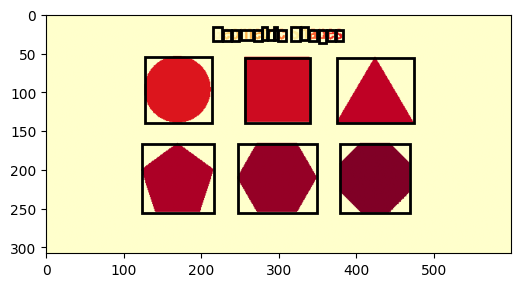

In [4]:
#2. Viet chuong trinh gan nhan anh
#2.1 Gan nhan anh
from PIL import Image
import numpy as np
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

# Đọc ảnh và chuyển sang ảnh xám
data = Image.open('geometric.png').convert('L')
a = np.asarray(data)

# Áp dụng ngưỡng Otsu để phân ngưỡng ảnh
thres = threshold_otsu(a)
b = a > thres  # Giữ lại các pixel có cường độ lớn hơn ngưỡng

# Gán nhãn cho ảnh nhị phân
c = label(b)
cl = Image.fromarray(c.astype(np.uint8)) # Convert to uint8 for saving as PNG
iio.imsave('label_output.png', cl) # Save as PNG

# Trích xuất các thuộc tính vùng từ ảnh đã gán nhãn
properties = ['Area', 'Centroid', 'BoundingBox']
d = regionprops(c)

# Tạo một hình vẽ trống kích thước 6x6 inch
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(c, cmap='YlOrRd')

# Vẽ hộp bao quanh các đối tượng đã phát hiện
for i in d:
    lr, lc, ur, uc = i['BoundingBox']
    rec_width = uc - lc
    rec_height = ur - lr

    rect = mpatches.Rectangle(
        (lc, lr), rec_width, rec_height,
        fill=False, edgecolor='black', linewidth=2
    )
    ax.add_patch(rect)

plt.show()

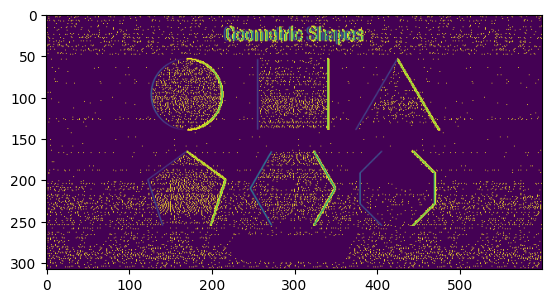

In [5]:
#2.2.	Dò tìm cạnh theo chiều dọc
from PIL import Image
import numpy as np
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

# Đọc ảnh và chuyển sang ảnh xám
data = Image.open('geometric.png').convert('L')

# Tính độ chênh lệch tuyệt đối giữa ảnh gốc và ảnh dịch phải 1 pixel
bmg = abs(data - nd.shift(data, (0, 1), order=0))

# Hiển thị ảnh kết quả
plt.imshow(bmg)
plt.show()


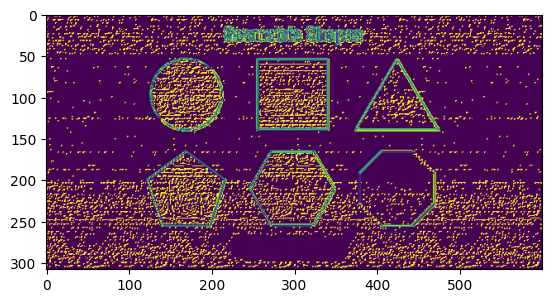

In [6]:
#2.3.	Dò tìm cạnh với Sobel Filter
from PIL import Image
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

# Đọc ảnh và chuyển sang ảnh xám
data = Image.open('geometric.png').convert('L')

# Tính đạo hàm Sobel theo hai trục x (axis=1) và y (axis=0)
a = nd.sobel(data, axis=0)  # Đạo hàm theo trục dọc (y)
b = nd.sobel(data, axis=1)  # Đạo hàm theo trục ngang (x)

# Tính độ lớn biên bằng tổng trị tuyệt đối theo cả hai trục
bmg = abs(a) + abs(b)

# Hiển thị ảnh biên
plt.imshow(bmg)
plt.show()


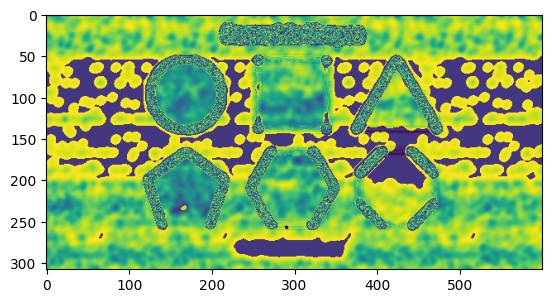

In [7]:
#2.4.	Xác định góc của đối tượng
from PIL import Image
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

# Hàm tính phản hồi Harris
def Harris(indata, alpha=0.2):
    x = nd.sobel(indata, 0)   # Gradient theo trục y
    y = nd.sobel(indata, 1)   # Gradient theo trục x

    xl = x ** 2               # Ixx
    yl = y ** 2               # Iyy
    xy = abs(x * y)           # Ixy (lấy trị tuyệt đối)

    # Làm mượt các ảnh đạo hàm
    xl = nd.gaussian_filter(xl, 3)
    yl = nd.gaussian_filter(yl, 3)
    xy = nd.gaussian_filter(xy, 3)

    # Tính determinant và trace của ma trận cấu trúc
    detC = xl * yl - 2 * xy
    trC = xl + yl

    # Công thức phản hồi Harris
    R = detC - alpha * (trC ** 2)
    return R

# Đọc ảnh đầu vào và chuyển sang grayscale
data = Image.open('geometric.png').convert('L')

# Gọi hàm Harris để tính ảnh phản hồi góc
bmg = Harris(data)

# Hiển thị ảnh kết quả
plt.imshow(bmg)
plt.show()


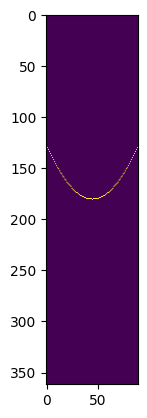

In [9]:
#2.5.	Dò tìm hình dạng cụ thể trong ảnh với Hough Transform
#2.5.1.	Dò tìm đường thẳng trong ảnh
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

# Hàm thực hiện biến đổi Hough tuyến tính
def LineHough(data, gamma):
    V, H = data.shape
    R = int(np.sqrt(V * V + H * H))   # Bán kính cực đại trong không gian Hough
    ho = np.zeros((R, 90), float)     # Không gian Hough (r, theta)

    w = data + 0                      # Sao chép ảnh đầu vào
    ok = 1                            # Cờ kiểm tra vòng lặp

    theta = np.arange(90) / 180.0 * np.pi
    tp = np.arange(90).astype(float)

    while ok:
        mx = w.max()
        if mx < gamma:
            ok = 0
        else:
            v, h = divmod(w.argmax(), H)  # Tìm vị trí pixel có giá trị lớn nhất
            y = V - v
            x = h

            rh = x * np.cos(theta) + y * np.sin(theta)
            for i in range(len(rh)):
                if 0 <= rh[i] < R and 0 <= tp[i] < 90:
                    ho[int(rh[i]), int(tp[i])] += mx
            w[v, h] = 0  # Xóa điểm đã xử lý khỏi ảnh đầu vào

    return ho

# Tạo ảnh nhị phân đầu vào với một điểm duy nhất tại (128, 128)
data = np.zeros((256, 256))
data[128, 128] = 1

# Thực hiện biến đổi Hough với ngưỡng gamma = 0.5
bmg = LineHough(data, 0.5)

# Hiển thị ảnh kết quả trong không gian Hough
plt.imshow(bmg)
plt.show()


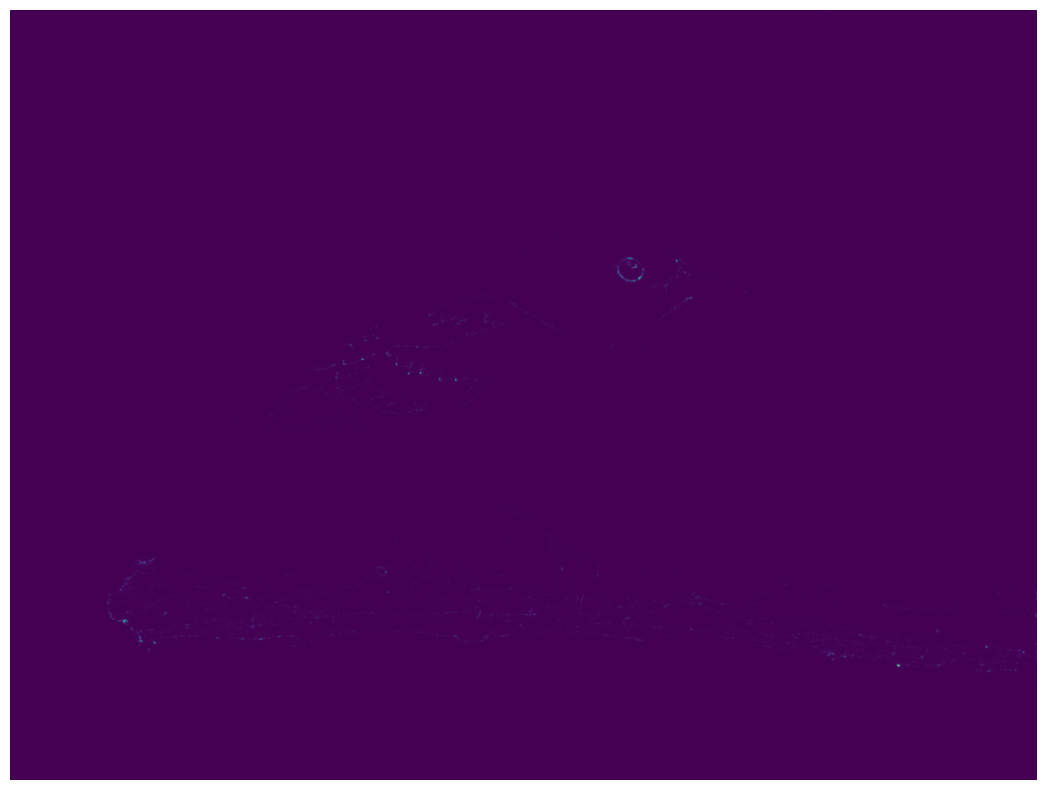

In [11]:
#2.5.2.	Dò tìm đường tròn trong ảnh
from PIL import Image
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.feature import corner_harris
from skimage.color import rgb2gray

# Đọc ảnh từ file
data = iio.imread('bird.png')

# Chuyển ảnh sang thang xám
image_gray = rgb2gray(data)

# Tính ma trận phản hồi Harris
coordinate = corner_harris(image_gray, k=0.001)

# Hiển thị ảnh phản hồi Harris
plt.figure(figsize=(20, 10))
plt.imshow(coordinate)
plt.axis('off')
plt.show()


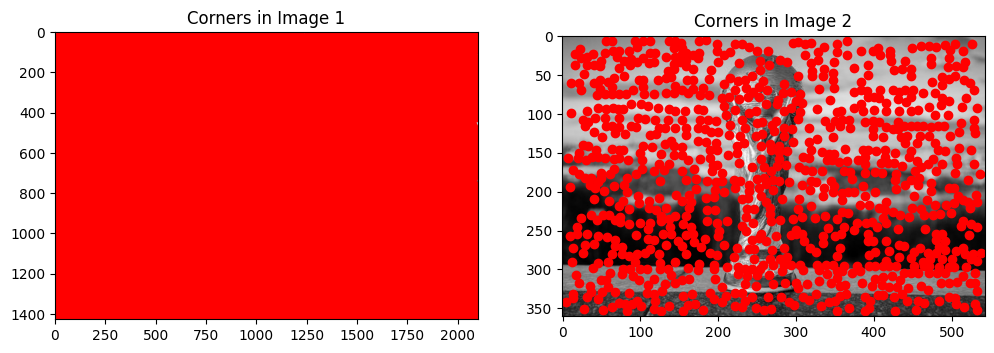

In [14]:
#2.6.	Image matching
#Phát hiện điểm đặc trưng bằng Harris Corner Detector
from skimage.feature import corner_harris, corner_peaks
from skimage.color import rgb2gray
from skimage import io
import matplotlib.pyplot as plt

# Đọc ảnh và chuyển sang ảnh xám
img1 = rgb2gray(io.imread('fruit.jpg'))
img2 = rgb2gray(io.imread('cup.jpg'))

# Phát hiện điểm góc bằng Harris
corners1 = corner_peaks(corner_harris(img1), min_distance=5)
corners2 = corner_peaks(corner_harris(img2), min_distance=5)

# Hiển thị kết quả
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img1, cmap='gray')
ax[0].plot(corners1[:, 1], corners1[:, 0], 'ro')
ax[0].set_title("Corners in Image 1")

ax[1].imshow(img2, cmap='gray')
ax[1].plot(corners2[:, 1], corners2[:, 0], 'ro')
ax[1].set_title("Corners in Image 2")
plt.show()
